# Batch Normalization in practice, an example with Keras and TensorFlow 2.0

This is a notebook for the medium article [Batch Normalization in practice, an example with Keras and TensorFlow 2.0](https://medium.com/@bindiatwork/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f)

Please check out article for instructions

**License**: [BSD 2-Clause](https://opensource.org/licenses/BSD-2-Clause)

**tf.keras.layers.BatchNormalization**

*Layer that normalizes its inputs.*

tf.keras.layers.BatchNormalization(

    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    synchronized=False,
    **kwargs
)

**Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.**

**Importantly, batch normalization works differently during training and during inference.**

------------------------------------------------------------------
**During training** (i.e. when using fit() or when calling the layer/model with the argument training=True), the layer normalizes its output using the mean and standard deviation of the current batch of inputs. That is to say, for each channel being normalized, the layer returns gamma * (batch - mean(batch)) / sqrt(var(batch) + epsilon) + beta, where:

epsilon is small constant (configurable as part of the constructor arguments)
gamma is a learned scaling factor (initialized as 1), which can be disabled by passing scale=False to the constructor.
beta is a learned offset factor (initialized as 0), which can be disabled by passing center=False to the constructor.
--------------------------------------------------------------------
**During inference** (i.e. when using evaluate() or predict() or when calling the layer/model with the argument training=False (which is the default), the layer normalizes its output using a moving average of the mean and standard deviation of the batches it has seen during training. That is to say, it returns gamma * (batch - self.moving_mean) / sqrt(self.moving_var+epsilon) + beta.

self.moving_mean and self.moving_var are non-trainable variables that are updated each time the layer in called in training mode, as such:

moving_mean = moving_mean * momentum + mean(batch) * (1 - momentum)
moving_var = moving_var * momentum + var(batch) * (1 - momentum)
----------------------------------------------------------------------------


In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

## Exploring data

In [3]:
# Load data into a DataFrame
df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Convert datatype to float
df = df.astype(float)
# append "target" and name it "label"
df['label'] = iris.target
# Use string label instead
df['label'] = df.label.replace(dict(enumerate(iris.target_names)))

In [4]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Preparing data for Keras and TensorFlow

In [5]:
# label -> one-hot encoding
label = pd.get_dummies(df['label'], prefix='label')
df = pd.concat([df, label], axis=1)
# drop old label
df.drop(['label'], axis=1, inplace=True)

In [6]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_setosa,label_versicolor,label_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [7]:
# Creating X and y

X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
# Convert DataFrame into np array
X = np.asarray(X)

y = df[['label_setosa', 'label_versicolor', 'label_virginica']]
# Convert DataFrame into np array
y = np.asarray(y)

In [8]:
# Split the data set in a training set (80%) and a test set (20%)
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.20
)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120, 4)
(30, 4)
(120, 3)
(30, 3)


### Batch normalization

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

In [11]:
# Model without batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
]);

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 37763 (147.51 KB)
Trainable params: 37763 

#### With batch normalization

In [13]:
# Model with batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(3, activation='softmax')
]);

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                320       
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_7 (Bat  (None, 128)              

#### With a customized batch normalization

In [14]:
from tensorflow.keras.initializers import RandomNormal, Constant

# Model with a customized batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(
        momentum=0.95,
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
        gamma_initializer=Constant(value=0.9)
    ),
    Dense(3, activation='softmax')
]);

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                320       
                                                                 
 batch_normalization_10 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_19 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_11 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_12 (Ba  (None, 128)              

### Training

Let's now compile and fit our model with batch normalisation

First we compile our model.

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

After that, let's fit our model to the training data.

In [17]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_split=0.25,
    batch_size=40,
    verbose=2
)

Epoch 1/200
3/3 - 3s - loss: 1.1010 - accuracy: 0.5111 - val_loss: 1.1007 - val_accuracy: 0.3333 - 3s/epoch - 1s/step
Epoch 2/200
3/3 - 0s - loss: 0.2566 - accuracy: 0.9778 - val_loss: 1.0817 - val_accuracy: 0.4000 - 62ms/epoch - 21ms/step
Epoch 3/200
3/3 - 0s - loss: 0.0960 - accuracy: 1.0000 - val_loss: 1.0710 - val_accuracy: 0.4000 - 41ms/epoch - 14ms/step
Epoch 4/200
3/3 - 0s - loss: 0.0971 - accuracy: 0.9778 - val_loss: 1.0678 - val_accuracy: 0.4000 - 46ms/epoch - 15ms/step
Epoch 5/200
3/3 - 0s - loss: 0.0513 - accuracy: 1.0000 - val_loss: 1.0656 - val_accuracy: 0.4000 - 46ms/epoch - 15ms/step
Epoch 6/200
3/3 - 0s - loss: 0.0622 - accuracy: 0.9889 - val_loss: 1.0781 - val_accuracy: 0.4000 - 63ms/epoch - 21ms/step
Epoch 7/200
3/3 - 0s - loss: 0.0660 - accuracy: 0.9889 - val_loss: 1.0975 - val_accuracy: 0.4000 - 52ms/epoch - 17ms/step
Epoch 8/200
3/3 - 0s - loss: 0.0336 - accuracy: 1.0000 - val_loss: 1.1206 - val_accuracy: 0.4000 - 44ms/epoch - 15ms/step
Epoch 9/200
3/3 - 0s - loss:

### Model Evaluation

Finally, we plot training and validation loss and accuracy to observe how the accuracy of our model improves over time.

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

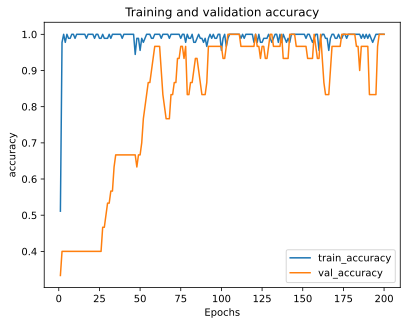

In [19]:
plot_metric(history, 'accuracy')

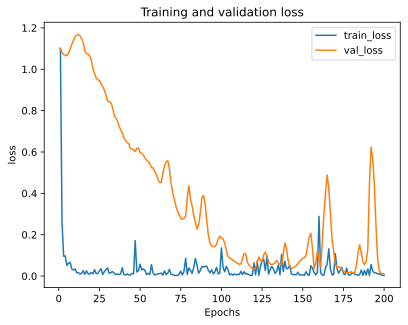

In [20]:
plot_metric(history, 'loss')

In [21]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - loss: 0.2917 - accuracy: 0.9667 - 37ms/epoch - 37ms/step


[0.29168325662612915, 0.9666666388511658]

## That's it

Thanks for reading

This is a notebook for the medium article [Batch Normalization in practice: an example with Keras and TensorFlow 2.0](https://medium.com/@bindiatwork/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f)

Please check out article for instructions